In [1]:
import torch
import transformer_lens
from backward_search.utils.nodes import ATTN_Node
from backward_search_approximated.utils.nodes import ATTN_ApproxNode, EMBED_ApproxNode, FINAL_ApproxNode, MLP_ApproxNode

# autoreload
%load_ext autoreload
%autoreload 2

model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small", device='cpu', dtype=torch.float32)

model.eval()

print("Model loaded successfully.")
prompt = 'When John and Mary went to the shops. John gave the bag to'
answer = ' Mary'
answer_ids = model.to_tokens(answer, prepend_bos=False)
logits, cache = model.run_with_cache(prompt, return_type='logits', prepend_bos=True, device='cpu')

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


Loaded pretrained model gpt2-small into HookedTransformer
Model loaded successfully.


## Attention Patching

In [26]:
def get_top_k_probs(residual, position, k=5):
	residual = residual[:, position, :]  # Get the last token's logits
	residual = model.ln_final(residual)  # Apply layer normalization
	logits = model.unembed(residual)
	probs = torch.softmax(logits, dim=-1)  # Apply softmax to get probabilities
	top_k_probs, top_k_indices = torch.topk(probs, k=k, dim=-1)
	top_k_strings = model.to_str_tokens(top_k_indices)
	return top_k_probs, top_k_indices, top_k_strings


In [27]:
def get_path_msg(path, message=None):
	if len(path) == 0:
		return message
	message = path[0].forward(message=message)
	return get_path_msg(path[1:], message=message)

get_path_msg([attn])[:,:,:5]

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0013, -0.0117,  0.0036,  0.0090, -0.0026]]])

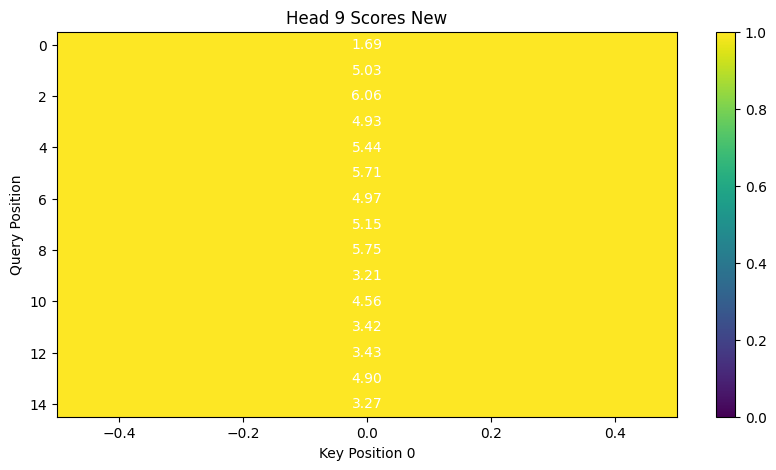

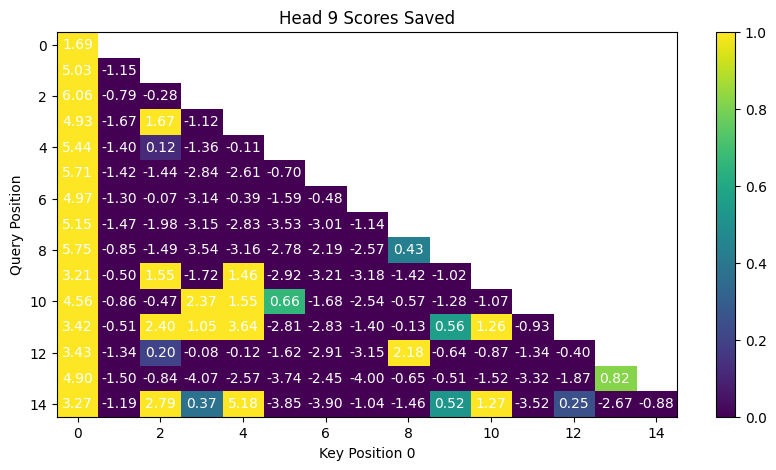

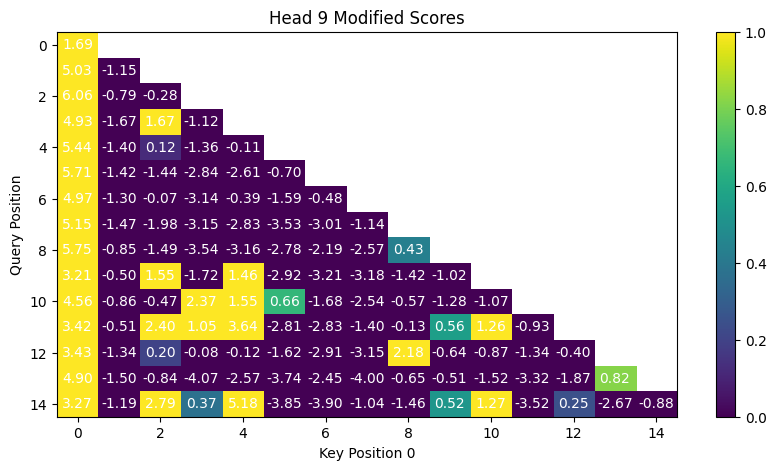

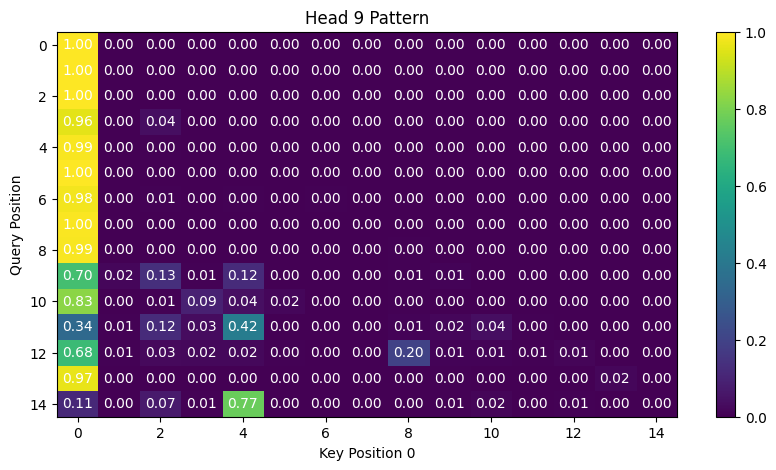

tensor([[[-0.0110, -0.1026,  0.0314,  ...,  0.0661,  0.0636, -0.0898],
         [-0.0110, -0.1024,  0.0313,  ...,  0.0660,  0.0634, -0.0896],
         [-0.0110, -0.1024,  0.0313,  ...,  0.0660,  0.0634, -0.0895],
         ...,
         [-0.0075, -0.0701,  0.0215,  ...,  0.0452,  0.0434, -0.0613],
         [-0.0107, -0.0992,  0.0303,  ...,  0.0639,  0.0614, -0.0867],
         [-0.0013, -0.0117,  0.0036,  ...,  0.0076,  0.0073, -0.0103]]],
       grad_fn=<UnsafeViewBackward0>)

In [28]:
ATTN_ApproxNode(
		model=model,
		layer=9,
		head=9,
		position=None,
		keyvalue_position=0,
		patch_key=True,
		patch_value=True,
		patch_query=False,
		msg_cache=dict(cache),
		plot_patterns=True
	).forward(message=None)

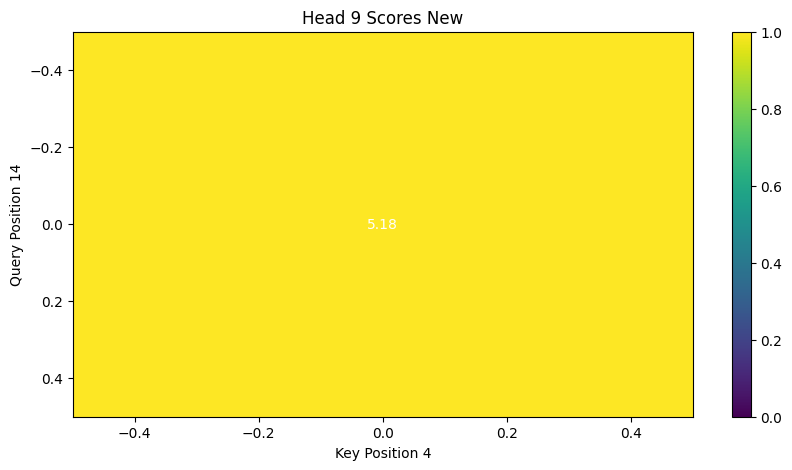

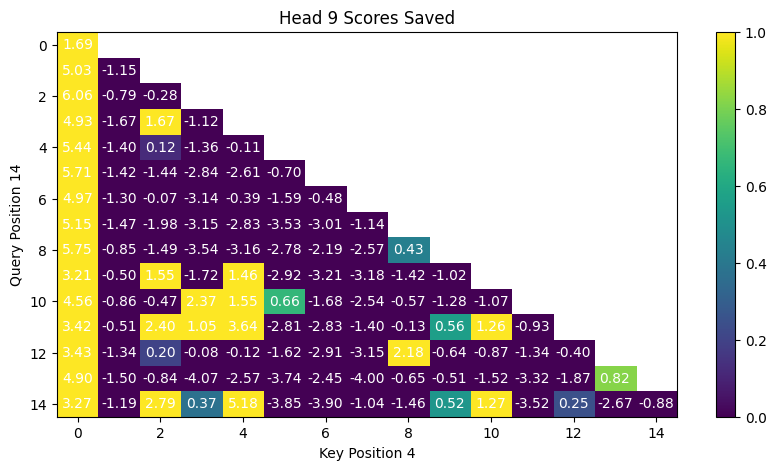

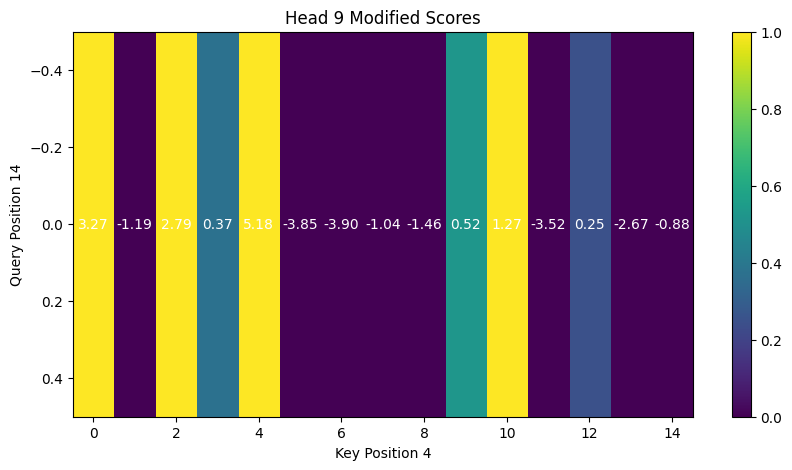

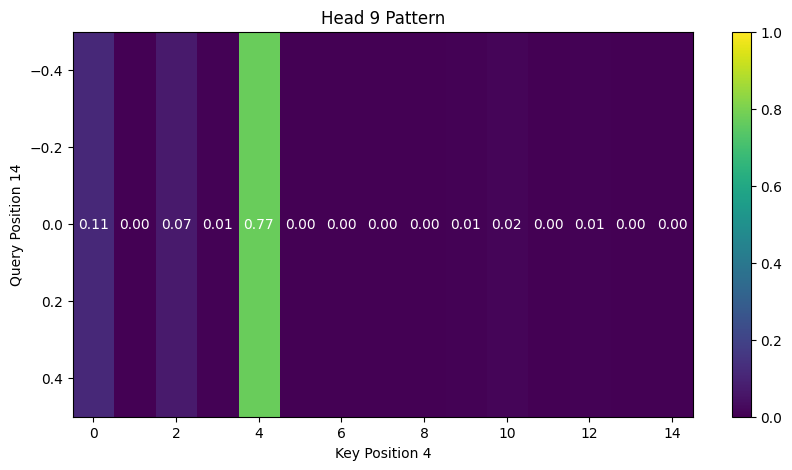

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0703, -0.7295, -0.4302,  ..., -0.6969, -1.2735,  2.2098]]],
       grad_fn=<CopySlices>)

In [43]:
attn = ATTN_ApproxNode(
		model=model,
		layer=9,
		head=9,
		position=14,
		keyvalue_position=4,
		patch_key=True,
		patch_value=True,
		patch_query=True,
		msg_cache=dict(cache),
		plot_patterns=True
	)
attn.forward(message=None)

In [30]:
attn.forward(message=None)

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0703, -0.7295, -0.4302,  ..., -0.6969, -1.2735,  2.2098]]])

In [31]:
msg_cache = dict(cache)


attn = ATTN_ApproxNode(
	model=model,
	layer=9,
	head=9,
	position=14,
	keyvalue_position=None,
	patch_key=False,
	patch_value=False,
	patch_query=True,
	msg_cache=msg_cache,
	plot_patterns=False
)
x = attn.forward(message=None)
y = attn.forward(message=None)
print(torch.allclose(x,y, atol=1e-5))
z = get_path_msg([attn])
print(torch.allclose(x, z, atol=1e-5))
print(torch.allclose(y, z))

True
True
True


In [ ]:
from backward_search_approximated.utils.metrics import compare_token_logit
from backward_search_approximated.utils.graph_search import get_path_msg
msg_cache = dict(cache)

print("\n\nAnalyzing keyvalue position patching")
for input_position in range(0, 15):
	print(f"\nKEYVALUE - Input position: {input_position}")
	attn = ATTN_ApproxNode(
		model=model,
		layer=9,
		head=9,
		position=14,
		keyvalue_position=input_position,
		patch_key=True,
		patch_value=True,
		patch_query=False,
		msg_cache=msg_cache,
		plot_patterns=False
	)
	result = attn.forward(message=0.999*cache['blocks.9.hook_resid_pre']) # Note I am using 0.999 to avoid zeroing out value residual, which makes the key contribution pointless
	probs, indices, strings = get_top_k_probs(result, 14)
	print(f"        Top 5 tokens: {strings} - Probabilities: {probs[0]}")
	print("       ", compare_token_logit(cache['blocks.11.hook_resid_post'], cache['blocks.11.hook_resid_post'] - result, model, target_tokens=answer_ids[0]).item())
	print(f"KEY - Input position: {input_position}")
	attn = ATTN_ApproxNode(
		model=model,
		layer=9,
		head=9,
		position=14,
		keyvalue_position=input_position,
		patch_key=True,
		patch_value=False,
		patch_query=False,
		msg_cache=msg_cache,
		plot_patterns=False
	)
	result = attn.forward(message=0.999*cache['blocks.9.hook_resid_pre'])
	probs, indices, strings = get_top_k_probs(result, 14)
	print(f"        Top 5 tokens: {strings} - Probabilities: {probs[0]}")
	print("       ", compare_token_logit(cache['blocks.11.hook_resid_post'], cache['blocks.11.hook_resid_post'] - result, model, target_tokens=answer_ids[0]).item())
	print(f"VALUE - Input position: {input_position}")
	attn = ATTN_ApproxNode(
		model=model,
		layer=9,
		head=9,
		position=14,
		keyvalue_position=input_position,
		patch_key=False,
		patch_value=True,
		patch_query=False,
		msg_cache=msg_cache,
		plot_patterns=False
	)
	result = attn.forward(message=0.999*cache['blocks.9.hook_resid_pre'])
	probs, indices, strings = get_top_k_probs(result, 14)
	print(f"        Top 5 tokens: {strings} - Probabilities: {probs[0]}")
	print("       ", compare_token_logit(cache['blocks.11.hook_resid_post'], cache['blocks.11.hook_resid_post'] - result, model, target_tokens=answer_ids[0]).item())

print("\n\nAnalyzing query position patching")
attn = ATTN_ApproxNode(
	model=model,
	layer=9,
	head=9,
	position=14,
	keyvalue_position=None,
	patch_key=False,
	patch_value=False,
	patch_query=True,
	msg_cache=msg_cache,
)
result = attn.forward(message=None)
probs, indices, strings = get_top_k_probs(result, 14)
print(f"Top 5 tokens: {strings} - Probabilities: {probs[0]}")
print(compare_token_logit(cache['blocks.11.hook_resid_post'], cache['blocks.11.hook_resid_post'] - result, model, target_tokens=answer_ids[0]).item())
assert torch.allclose(get_path_msg([attn]), result, atol=1e-5), "Path message does not match the result of the forward pass."



Analyzing keyvalue position patching

KEYVALUE - Input position: 0
        Top 5 tokens: [',', ' the', ' and', '.', '\n'] - Probabilities: tensor([0.0110, 0.0104, 0.0078, 0.0064, 0.0064], grad_fn=<SelectBackward0>)
        0.0
KEY - Input position: 0
        Top 5 tokens: [',', ' the', ' and', '.', '\n'] - Probabilities: tensor([0.0110, 0.0104, 0.0078, 0.0064, 0.0064], grad_fn=<SelectBackward0>)
        0.0
VALUE - Input position: 0
        Top 5 tokens: [',', ' the', ' and', '.', '\n'] - Probabilities: tensor([0.0110, 0.0104, 0.0078, 0.0064, 0.0064], grad_fn=<SelectBackward0>)
        0.0

KEYVALUE - Input position: 1
        Top 5 tokens: [',', ' the', ' and', '\n', ' a'] - Probabilities: tensor([0.0109, 0.0107, 0.0078, 0.0064, 0.0063], grad_fn=<SelectBackward0>)
        6.306149589363486e-05
KEY - Input position: 1
        Top 5 tokens: [',', ' the', ' and', '.', '\n'] - Probabilities: tensor([0.0103, 0.0082, 0.0072, 0.0067, 0.0055], grad_fn=<SelectBackward0>)
        -0.000378368

In [ ]:
from backward_search_approximated.utils.graph_search import evaluate_path

msg_cache = dict(cache)

path = [
ATTN_ApproxNode(
		model=model,
		layer=9,
		head=9,
		position=14,
		keyvalue_position=4,
		patch_key=True,
		patch_value=True,
		patch_query=False,
		msg_cache=msg_cache,
		plot_patterns=False
	), 
FINAL_ApproxNode(
		model=model,
		layer=11,
		position=14,
		parent=None,
		msg_cache=msg_cache,
	)
]
print("base evaluation", evaluate_path(model, cache, path, compare_token_logit, answer_ids[0]))

result = path[0].forward(message=None)

message1 = path[0].forward(message=None)
message2 = path[1].forward(message=message1)

assert torch.allclose(message1, result, atol=1e-5), "Messages are not close enough!"

assert torch.allclose(message1, message2, atol=1e-5), "Messages are not close enough!"
assert torch.allclose(path[-1].forward()[:,-1], cache['blocks.11.hook_resid_post'][:,-1]), "Final message does not match the expected output!"

print(compare_token_logit(path[-1].forward(), path[-1].forward() - message1.detach().clone(), model, target_tokens=answer_ids[0]))
print(compare_token_logit(cache['blocks.11.hook_resid_post'][:,-1:], cache['blocks.11.hook_resid_post'][:,-1:] - message2[:,-1:], model, target_tokens=answer_ids[0]))
print(compare_token_logit(cache['blocks.11.hook_resid_post'], cache['blocks.11.hook_resid_post'] - message1, model, target_tokens=answer_ids[0]))

base evaluation tensor(12.4072, grad_fn=<MeanBackward0>)
tensor(12.4072, grad_fn=<MeanBackward0>)
tensor(12.4072, grad_fn=<MeanBackward0>)
tensor(12.4072, grad_fn=<MeanBackward0>)


In [52]:
print(compare_token_logit(cache['blocks.11.hook_resid_post'], cache['blocks.11.hook_resid_post'] - message1, model, target_tokens=answer_ids[0]))

tensor(12.4072, grad_fn=<MeanBackward0>)


### Speedup achieved by the new attention implementation

In [56]:
attn = ATTN_Node(
	layer=9,
	head=9,
	position=14,
	keyvalue_position=4,
	patch_keyvalue=True,
	patch_query=True,
)

attn_approx = ATTN_ApproxNode(
	model=model,
	layer=9,
	head=9,
	position=14,
	keyvalue_position=4,
	patch_key=True,
	patch_value=True,
	patch_query=True,
	msg_cache=msg_cache,
)

%timeit result = attn.forward(model=model, cache=dict(cache), patch=torch.zeros_like(cache['blocks.9.hook_resid_pre']))

%timeit result_approx = attn_approx.forward(message=torch.zeros_like(cache['blocks.9.hook_resid_pre']))

19.5 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.65 ms ± 247 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


This achieves a close to 1.5x speedup if head is None or a 15x speedup for a single head!

## MLPs patching


In [ ]:
mlp = MLP_ApproxNode(
	model=model,
	layer=0,
	position=4,
	msg_cache=msg_cache,
)

result = mlp.forward(message=None)

assert torch.allclose(result[:,4], msg_cache['blocks.0.hook_mlp_out'][:,4], atol=1e-5), "Results are not close enough!"

## Gradient

### Cached gradient and insights on backpropagation

In [2]:
# def attention_score_patch_hook(residual: Tensor, hook: Any, new_scores: Tensor, head: int, in_pos: int, out_pos: int) -> Tensor:
# 	"residual has shape [bs, nheads, seq, seq]"
# 	residual[:, head, out_pos, in_pos] = new_scores

def token_logit_metric(model: transformer_lens.HookedTransformer, tokens, target_tokens):
	# Get logits for the last token position of ALL sequences in the batch
	# last_token_logits_all_sequences shape: (batch_size, d_vocab)
	last_token_logits_all_sequences = model.run_with_hooks(tokens)[:, -1, :]

	batch_size = tokens.shape[0]

	# Select the logit of the target token for each sequence in the batch
	clean_logits = last_token_logits_all_sequences[torch.arange(batch_size), target_tokens]
	return torch.mean(clean_logits)

def get_cache_fwd_and_bwd(model, tokens, targets, metric, hook_names=[], wrong_targets=None):
	model.reset_hooks()
	model.zero_grad()
	cache = {}

	def forward_cache_hook(residual, hook):
		cache[hook.name] = residual.detach()
	for name in hook_names:
		model.add_hook(name, forward_cache_hook, "fwd")

	grad_cache = {}

	def backward_cache_hook(residual, hook):
		grad_cache[hook.name] = residual.clone().detach()

	for name in hook_names:
		model.add_hook(name, backward_cache_hook, "bwd")
	
	if wrong_targets:
		value = metric(model, tokens, targets, wrong_targets)
	else:
		value = metric(model, tokens, targets)
	print(f"Metric value: {value.item()}")
	value.backward()
	model.reset_hooks()
	return (
		value.item(),
		transformer_lens.ActivationCache(cache, model),
		transformer_lens.ActivationCache(grad_cache, model),
	)


hook_names = [key for key in cache.keys() if ("attn_out" in key or "resid" in key or "mlp_out" in key or "embed" in key)]

correct_token_id = model.to_single_token(answer)
tokens = model.to_tokens(prompt, prepend_bos=True)

loss, cache_temp, grad_cache = get_cache_fwd_and_bwd(model, tokens, [correct_token_id], token_logit_metric, hook_names)
cache_temp = None
torch.cuda.empty_cache()

Metric value: 18.147512435913086


In [61]:
input_residual = cache['blocks.0.hook_resid_mid']

input_residual.requires_grad_(True)

output_precomputed = cache['blocks.0.hook_mlp_out']

with torch.enable_grad():
	output = model.blocks[0].mlp(model.blocks[0].ln2(input_residual))

assert torch.allclose(output, output_precomputed, atol=1e-6), "Output does not match precomputed output."


gradient_whole = torch.autograd.grad(
	output,
	input_residual,
	grad_outputs=grad_cache['blocks.0.hook_mlp_out'],
	retain_graph=True,
)[0]

# gradient from grad cache, removing the one due to the residual connection
gradient_precomputed = grad_cache['blocks.0.hook_resid_mid'] - grad_cache['blocks.0.hook_mlp_out']



assert torch.allclose(gradient_whole, gradient_precomputed, atol=1e-5), "Gradient does not match precomputed gradient."


### Get Gradiet from components

#### MLP

In [63]:
mlp_node = MLP_ApproxNode(
	model=model,
	layer=0,
	position=None,
	msg_cache=msg_cache,
)
input_residual = msg_cache['blocks.0.hook_resid_mid']
output_precomputed = msg_cache['blocks.0.hook_mlp_out']

result = mlp_node.forward(message=None)

assert torch.allclose(result, output_precomputed, atol=1e-5), "MLP ApproxNode output does not match precomputed output."

gradient_from_node = mlp_node.calculate_gradient(grad_outputs=grad_cache['blocks.0.hook_mlp_out'], use_precomputed=False)

assert torch.allclose(gradient_from_node, gradient_precomputed, atol=1e-5), "MLP ApproxNode gradient does not match precomputed gradient."


mlp_node = MLP_ApproxNode(
	model=model,
	layer=0,
	position=4,
	msg_cache=msg_cache,
)

gradient_from_node_pos = mlp_node.calculate_gradient(grad_outputs=grad_cache['blocks.0.hook_mlp_out'], use_precomputed=False)
assert torch.allclose(gradient_from_node_pos[:,:4,:], torch.zeros_like(gradient_from_node_pos[:,:4,:]), atol=1e-5), "MLP ApproxNode gradient for position 4 does not match precomputed gradient for positions before 4."

assert torch.allclose(gradient_from_node_pos[:,4,:], gradient_precomputed[:,4,:], atol=1e-5), "MLP ApproxNode gradient for position 4 does not match precomputed gradient for positions 4."

assert torch.allclose(gradient_from_node_pos[:,5:,:], torch.zeros_like(gradient_from_node_pos[:,5:,:]), atol=1e-5), "MLP ApproxNode gradient for positions after 4 does not match precomputed gradient for positions after 4."

In [64]:
gradient_from_node[0,0,:10], gradient_precomputed[0,0,:10]

(tensor([-0.0025, -0.0045, -0.0025, -0.0134, -0.0111,  0.0072, -0.0017, -0.0029,
          0.0066,  0.0095]),
 tensor([-0.0025, -0.0045, -0.0025, -0.0134, -0.0111,  0.0072, -0.0017, -0.0029,
          0.0066,  0.0095]))

#### ATTN

In [65]:
attn_node = ATTN_ApproxNode(
	model=model,
	layer=9,
	head=None,
	position=None,
	keyvalue_position=None,
	patch_key=True,
	patch_value=True,
	patch_query=True,
	msg_cache=dict(cache),
)

attn_node.forward(message=torch.zeros_like(cache['blocks.9.hook_resid_pre']))

tensor([[[ 0.1585, -0.1277,  0.0729,  ...,  0.1660, -0.1013,  0.4308],
         [ 0.1585, -0.1277,  0.0729,  ...,  0.1660, -0.1013,  0.4308],
         [ 0.1585, -0.1277,  0.0729,  ...,  0.1660, -0.1013,  0.4308],
         ...,
         [ 0.1585, -0.1277,  0.0729,  ...,  0.1660, -0.1013,  0.4308],
         [ 0.1585, -0.1277,  0.0729,  ...,  0.1660, -0.1013,  0.4308],
         [ 0.1585, -0.1277,  0.0729,  ...,  0.1660, -0.1013,  0.4308]]],
       grad_fn=<SubBackward0>)

In [70]:
attn_node = ATTN_ApproxNode(
	model=model,
	layer=9,
	head=None,
	position=None,
	keyvalue_position=None,
	patch_key=True,
	patch_value=True,
	patch_query=True,
	msg_cache=dict(cache),
)

grad = attn_node.calculate_gradient(grad_outputs=grad_cache['blocks.9.hook_attn_out'])

gradient_precomputed = grad_cache['blocks.9.hook_resid_pre'] - grad_cache['blocks.9.hook_attn_out']

assert torch.allclose(grad, gradient_precomputed, atol=1e-5), "ATTN ApproxNode gradient does not match precomputed gradient."
print("When considering a all heads the gradients are correct.\n")

grad = torch.zeros_like(grad)
for head in range(12):
	attn_node = ATTN_ApproxNode(
		model=model,
		layer=9,
		head=head,
		position=None,
		keyvalue_position=None,
		patch_key=True,
		patch_value=True,
		patch_query=True,
		msg_cache=dict(cache),
	)
	grad += attn_node.calculate_gradient(grad_outputs=grad_cache['blocks.9.hook_attn_out'])

assert torch.allclose(grad, gradient_precomputed, atol=1e-5), "ATTN ApproxNode gradient does not match precomputed gradient when considering all heads."
print("When considering a all heads one by one the gradients are correct.\n")


attn_node = ATTN_ApproxNode(
	model=model,
	layer=9,
	head=None,
	position=None,
	keyvalue_position=4,
	patch_key=True,
	patch_value=True,
	patch_query=True,
	msg_cache=dict(cache),
)

grad = attn_node.calculate_gradient(grad_outputs=grad_cache['blocks.9.hook_attn_out'])
assert torch.allclose(grad[:, :4, :], torch.zeros_like(grad[:, :4, :]), atol=1e-5), "ATTN ApproxNode gradient for keyvalue positions before 4 should be zero."



attn_node = ATTN_ApproxNode(
	model=model,
	layer=9,
	head=None,
	position=4,
	keyvalue_position=None,
	patch_key=True,
	patch_value=True,
	patch_query=True,
	msg_cache=dict(cache),
)

grad = attn_node.calculate_gradient(grad_outputs=grad_cache['blocks.9.hook_attn_out'])
assert torch.allclose(grad[:, 5:, :], torch.zeros_like(grad[:, 5:, :]), atol=1e-5), "ATTN ApproxNode gradient for keyvalue positions after 4 should be zero."

attn_node = ATTN_ApproxNode(
	model=model,
	layer=9,
	head=None,
	position=4,
	keyvalue_position=4,
	patch_key=True,
	patch_value=True,
	patch_query=True,
	msg_cache=dict(cache),
)

grad = attn_node.calculate_gradient(grad_outputs=grad_cache['blocks.9.hook_attn_out'])
assert torch.allclose(grad[:, :4, :], torch.zeros_like(grad[:, :4, :]), atol=1e-5), "ATTN ApproxNode gradient for keyvalue positions before 4 should be zero."
assert torch.allclose(grad[:, 5:, :], torch.zeros_like(grad[:, 5:, :]), atol=1e-5), "ATTN ApproxNode gradient for keyvalue positions after 4 should be zero."

attn_node = ATTN_ApproxNode(
	model=model,
	layer=9,
	head=9,
	position=10,
	keyvalue_position=4,
	patch_key=True,
	patch_value=True,
	patch_query=True,
	msg_cache=msg_cache,
)

grad = attn_node.calculate_gradient(grad_outputs=grad_cache['blocks.9.hook_attn_out'])
for i in range(15):
	if i != 4 and i != 10:
		assert torch.allclose(grad[:, i, :], torch.zeros_like(grad[:, i, :]), atol=1e-5), f"ATTN ApproxNode gradient for keyvalue position {i} should be zero."
print("When considering single positions the gradients are zeroed in the correct positions")

When considering a all heads the gradients are correct.

When considering a all heads one by one the gradients are correct.

When considering single positions the gradients are zeroed in the correct positions


#### FINAL

In [71]:
compare_token_logit(clean_resid=cache['blocks.11.hook_resid_post'], corrupted_resid=torch.zeros_like(cache['hook_embed']), model=model, target_tokens=[correct_token_id])

tensor(91.1645, grad_fn=<MeanBackward0>)

In [72]:
from functools import partial

final_node = FINAL_ApproxNode(
		model=model,
		layer=11,
		position=14,
		parent=None,
		msg_cache=msg_cache,
	)

metric = partial(compare_token_logit, clean_resid=cache['blocks.11.hook_resid_post'], model=model, target_tokens=[correct_token_id])
print(metric(corrupted_resid=torch.zeros_like(cache['hook_embed'])))
grad = final_node.calculate_gradient(metric=metric)

assert torch.allclose(grad[:, :-1, :], torch.zeros_like(grad[:, :-1, :]), atol=1e-3), "Gradients should be zero for positions different from the last one"

assert not torch.allclose(grad[:,-1,:], torch.zeros_like(grad[:,-1,:]), atol=1e-6), "Gradients should not be zero for the last position"


tensor(91.1645, grad_fn=<MeanBackward0>)


#### EMBED

In [75]:
embed_node = EMBED_ApproxNode(
		model=model,
		layer=0,
		position=4,
		parent=None,
		msg_cache=msg_cache
)

grad = embed_node.calculate_gradient()

assert torch.allclose(grad[:, :4, :], torch.zeros_like(grad[:, :4, :]), atol=1e-3), "Gradients should be zero for non involved positions"

assert torch.allclose(grad[:, 5:, :], torch.zeros_like(grad[:, 5:, :]), atol=1e-3), "Gradients should be zero for non involved positions"

assert torch.allclose(grad[:,4,:], torch.ones_like(grad[:,4,:]), atol=1e-6), "Gradients should be ones for the involved position"


## Run without gradient approximation

In [ ]:
from backward_search_approximated.utils.graph_search import breadth_first_search
from backward_search_approximated.utils.metrics import compare_token_logit


correct_token_id = model.to_single_token(answer)
msg_cache = dict(cache)
search = breadth_first_search(
	model=model,
	cache=msg_cache,
	metric=compare_token_logit,
	ground_truth_tokens=[correct_token_id],
	start_node=[FINAL_ApproxNode(
		model=model,
		layer=11,
		metric=compare_token_logit,
		position=14,
		parent=None,
		msg_cache=msg_cache,
		)],
	min_contribution=4
)

(1)    Frontier: [(91.5, [FINAL_ApproxNode(layer=11, position=14)])](total 1)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:19<00:00, 19.49s/it]


(28)    Frontier: [(12.5, [ATTN_ApproxNode(layer=9, head=9, position=14, keyvalue_position=None, patch_query=True, patch_keyvalue=False), FINAL_ApproxNode(layer=11, position=14)]), (10.4375, [ATTN_ApproxNode(layer=9, head=6, position=14, keyvalue_position=None, patch_query=True, patch_keyvalue=False), FINAL_ApproxNode(layer=11, position=14)]), (9.75, [ATTN_ApproxNode(layer=11, head=2, position=14, keyvalue_position=4, patch_query=False, patch_keyvalue=True), FINAL_ApproxNode(layer=11, position=14)]), (7.65625, [ATTN_ApproxNode(layer=10, head=10, position=14, keyvalue_position=9, patch_query=False, patch_keyvalue=True), FINAL_ApproxNode(layer=11, position=14)]), (6.9375, [ATTN_ApproxNode(layer=10, head=10, position=14, keyvalue_position=7, patch_query=False, patch_keyvalue=True), FINAL_ApproxNode(layer=11, position=14)]), (6.9375, [ATTN_ApproxNode(layer=11, head=4, position=14, keyvalue_position=11, patch_query=False, patch_keyvalue=True), FINAL_ApproxNode(layer=11, position=14)]), (6.9

  7%|▋         | 2/28 [00:12<02:38,  6.09s/it]

(11.12) [EMBED_ApproxNode(layer=0, position=4), ATTN_ApproxNode(layer=11, head=2, position=14, keyvalue_position=4, patch_query=False, patch_keyvalue=True), FINAL_ApproxNode(layer=11, position=14)]


 18%|█▊        | 5/28 [00:22<01:44,  4.56s/it]


KeyboardInterrupt: 

Note: this show that even gpt2-small is unfeasible to run on CPU

## Path Attribution Patching

In [85]:
cf_cache = dict(cache)

In [91]:
from backward_search_approximated.utils.graph_search import PathAttributionPatching
from backward_search_approximated.utils.metrics import compare_token_logit
from functools import partial
msg_cache = dict(cache)
counterfactual_cache = {}
for key in msg_cache.keys():
	counterfactual_cache[key] = torch.zeros_like(msg_cache[key], device=msg_cache[key].device)
metric = partial(compare_token_logit, clean_resid=cache['blocks.11.hook_resid_post'], model=model, target_tokens=[correct_token_id])
cf_cache = dict(cache)
paths = PathAttributionPatching(
	model=model,
	msg_cache=msg_cache,
	metric=compare_token_logit,
	root= FINAL_ApproxNode(
		model=model,
		layer=11,
		metric=metric,
		position=14,
		parent=None,
		msg_cache=msg_cache,
		cf_cache=cf_cache,
		patch_type='counterfactual',
		),
	ground_truth_tokens=[correct_token_id],
	min_contribution = 0.75,
	include_negative=True,
)

[FINAL_ApproxNode(layer=11, position=14)]


100%|██████████| 1/1 [00:19<00:00, 19.42s/it]


[MLP_ApproxNode(layer=7, position=14), MLP_ApproxNode(layer=8, position=14), MLP_ApproxNode(layer=0, position=14), MLP_ApproxNode(layer=11, position=14), MLP_ApproxNode(layer=9, position=14), MLP_ApproxNode(layer=10, position=14)]


100%|██████████| 6/6 [00:00<00:00,  6.62it/s]


[MLP_ApproxNode(layer=5, position=14), ATTN_ApproxNode(layer=8, head=3, position=14, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=7, head=9, position=14, keyvalue_position=10, patch_query=False, patch_key=True, patch_value=True), ATTN_ApproxNode(layer=7, head=9, position=14, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=5, head=9, position=14, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=11, position=14, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=10, position=14, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=9, position=14, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=5, position=14, keyvalue_position=None, patch_query=True,

100%|██████████| 107/107 [00:12<00:00,  8.59it/s]


[MLP_ApproxNode(layer=0, position=14), ATTN_ApproxNode(layer=0, head=11, position=10, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), MLP_ApproxNode(layer=0, position=9), ATTN_ApproxNode(layer=0, head=11, position=9, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=1, head=10, position=9, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=1, head=4, position=9, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=1, head=2, position=9, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), MLP_ApproxNode(layer=10, position=9), ATTN_ApproxNode(layer=1, head=8, position=9, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=1, head=8, position=9, keyvalue_position=0, patch_query=False, patch_key=True, patch_value=True), ATTN_ApproxNode(la

100%|██████████| 208/208 [00:09<00:00, 20.82it/s]


[ATTN_ApproxNode(layer=0, head=10, position=9, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=11, position=9, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=9, position=9, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=11, position=9, keyvalue_position=0, patch_query=False, patch_key=True, patch_value=True), ATTN_ApproxNode(layer=0, head=11, position=9, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=9, position=9, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=11, position=9, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=9, position=14, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_

100%|██████████| 145/145 [00:02<00:00, 53.58it/s]


[ATTN_ApproxNode(layer=0, head=11, position=9, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=9, position=9, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=11, position=10, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=9, position=10, keyvalue_position=0, patch_query=False, patch_key=True, patch_value=True), ATTN_ApproxNode(layer=0, head=6, position=10, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=9, position=10, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=11, position=10, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=11, position=11, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), A

100%|██████████| 27/27 [00:00<00:00, 125.77it/s]


[ATTN_ApproxNode(layer=0, head=11, position=11, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=9, position=11, keyvalue_position=None, patch_query=True, patch_key=False, patch_value=False), ATTN_ApproxNode(layer=0, head=11, position=11, keyvalue_position=0, patch_query=False, patch_key=True, patch_value=True), ATTN_ApproxNode(layer=0, head=9, position=11, keyvalue_position=0, patch_query=False, patch_key=True, patch_value=True)]


100%|██████████| 4/4 [00:00<00:00, 54.78it/s]


In [92]:
for key in msg_cache.keys():
	assert torch.allclose(msg_cache[key], cf_cache[key], atol=1e-5), f"Counterfactual cache for {key} should be zeroed out."

In [82]:
node.cf_cache

{}

In [96]:
for path in paths:
	for node in path[1]:
		fwd = node.forward(message=None)
		print(node.msg_cache['hook_embed'][:,:,:5])
		print(node.cf_cache['hook_embed'][:,:,:5])
		print(fwd[:,:,:5])
		print(torch.max(fwd))
		assert torch.allclose(node.msg_cache[node.output_name], node.cf_cache[node.output_name], atol=1e-5), f"Message cache for {node.output_name} does not match the counterfactual cache."
		
		assert torch.allclose(fwd, torch.zeros_like(msg_cache[node.output_name]), atol=1e-5), f"Forward pass of {node} does not match the cached message for {node.output_name}."

tensor([[[ 0.0517, -0.0274,  0.0502, -0.0419, -0.0614],
         [ 0.0134, -0.0400,  0.0296, -0.0724, -0.1254],
         [ 0.0215, -0.0009,  0.2063,  0.0780, -0.0360],
         [-0.0521, -0.0004,  0.0310,  0.0224,  0.0254],
         [ 0.0777, -0.0227,  0.0806, -0.0379, -0.0245],
         [ 0.0623, -0.1351,  0.1448, -0.0055,  0.1368],
         [-0.0063, -0.0997,  0.0330,  0.0333,  0.0562],
         [-0.0381,  0.0062,  0.0433,  0.0410, -0.0350],
         [ 0.1845, -0.1412,  0.1433, -0.2148,  0.0783],
         [ 0.0462, -0.0118,  0.0279,  0.0459,  0.0386],
         [ 0.0215, -0.0009,  0.2063,  0.0780, -0.0360],
         [ 0.0769, -0.0674,  0.1171, -0.0588, -0.0170],
         [-0.0381,  0.0062,  0.0433,  0.0410, -0.0350],
         [ 0.1428,  0.0270,  0.0461, -0.0963, -0.0954],
         [-0.0063, -0.0997,  0.0330,  0.0333,  0.0562]]])
tensor([[[ 0.0517, -0.0274,  0.0502, -0.0419, -0.0614],
         [ 0.0134, -0.0400,  0.0296, -0.0724, -0.1254],
         [ 0.0215, -0.0009,  0.2063,  0.0780, 

AssertionError: Forward pass of EMBED_ApproxNode(layer=0, position=14) does not match the cached message for hook_embed.

**Note:** Now it is super fast even on CPU!!!!

In [58]:
for key in counterfactual_cache.keys():
	assert torch.allclose(counterfactual_cache[key], torch.zeros_like(counterfactual_cache[key]), atol=1e-5), f"Counterfactual cache for {key} should be zeroed out."

In [63]:
cf_cache_temp = {}
for key in dict(cache).keys():
	cf_cache_temp[key] = torch.zeros_like(cache[key], device=cache[key].device)
path[-2].cf_cache = cf_cache_temp
fw2_no_cache = path[-2].forward(message=None)

assert torch.allclose(fw2_no_cache, fw2, atol=1e-5), "Forward pass without cache does not match the expected output."

In [62]:
path = paths[0][1]
message = None

fw1 = path[-1].forward(message=message)

assert torch.allclose(fw1[:,-1], cache['blocks.11.hook_resid_post'][:,-1], atol=1e-5), "Final message does not match the expected output!"



fw2 = path[-2].forward(message=message)

assert torch.allclose(fw2[:,-1], msg_cache[path[-2].output_name][:,-1], atol=1e-5), "Final message does not match the expected output!"

fw3 = path[-3].forward(message=message)

assert torch.allclose(fw3[:,4], msg_cache[path[-3].output_name][:,4], atol=1e-5), "Final message does not match the expected output!"

In [61]:
print(len(paths), paths[:2], paths[-2:])
count_pos = 0
count_neg = 0
for path in paths:
	if path[0].item() >= 0.375:
		count_pos += 1
	if path[0].item() < -0.375:
		count_neg += 1

print(f"Positive paths: {count_pos}, Negative paths: {count_neg}")
print(f"Total paths: {len(paths)}")
print(f"Not relevant paths: {len(paths) - count_pos - count_neg}")

272 [(tensor(6.6421, grad_fn=<MeanBackward0>), [EMBED_ApproxNode(layer=0, position=4), MLP_ApproxNode(layer=0, position=4), ATTN_ApproxNode(layer=9, head=9, position=14, keyvalue_position=4, patch_query=False, patch_key=True, patch_value=True), FINAL_ApproxNode(layer=11, position=14)]), (tensor(2.8812, grad_fn=<MeanBackward0>), [EMBED_ApproxNode(layer=0, position=4), MLP_ApproxNode(layer=0, position=4), ATTN_ApproxNode(layer=10, head=0, position=14, keyvalue_position=4, patch_query=False, patch_key=True, patch_value=True), FINAL_ApproxNode(layer=11, position=14)])] [(tensor(-6.8237, grad_fn=<MeanBackward0>), [EMBED_ApproxNode(layer=0, position=4), MLP_ApproxNode(layer=0, position=4), ATTN_ApproxNode(layer=11, head=10, position=14, keyvalue_position=4, patch_query=False, patch_key=True, patch_value=True), FINAL_ApproxNode(layer=11, position=14)]), (tensor(-9.1412, grad_fn=<MeanBackward0>), [EMBED_ApproxNode(layer=0, position=4), MLP_ApproxNode(layer=0, position=4), ATTN_ApproxNode(layer

In [ ]:
print(len(paths), paths[:2], paths[-2:])
count_pos = 0
count_neg = 0
for path in paths:
	if path[0].item() >= 0.375:
		count_pos += 1
	if path[0].item() < -0.375:
		count_neg += 1

print(f"Positive paths: {count_pos}, Negative paths: {count_neg}")
print(f"Total paths: {len(paths)}")
print(f"Not relevant paths: {len(paths) - count_pos - count_neg}")

272 [(tensor(6.6421, grad_fn=<MeanBackward0>), [EMBED_ApproxNode(layer=0, position=4), MLP_ApproxNode(layer=0, position=4), ATTN_ApproxNode(layer=9, head=9, position=14, keyvalue_position=4, patch_query=False, patch_key=True, patch_value=True), FINAL_ApproxNode(layer=11, position=14)]), (tensor(2.8812, grad_fn=<MeanBackward0>), [EMBED_ApproxNode(layer=0, position=4), MLP_ApproxNode(layer=0, position=4), ATTN_ApproxNode(layer=10, head=0, position=14, keyvalue_position=4, patch_query=False, patch_key=True, patch_value=True), FINAL_ApproxNode(layer=11, position=14)])] [(tensor(-6.8237, grad_fn=<MeanBackward0>), [EMBED_ApproxNode(layer=0, position=4), MLP_ApproxNode(layer=0, position=4), ATTN_ApproxNode(layer=11, head=10, position=14, keyvalue_position=4, patch_query=False, patch_key=True, patch_value=True), FINAL_ApproxNode(layer=11, position=14)]), (tensor(-9.1412, grad_fn=<MeanBackward0>), [EMBED_ApproxNode(layer=0, position=4), MLP_ApproxNode(layer=0, position=4), ATTN_ApproxNode(layer

In [85]:
from backward_search_approximated.utils.graph_search import get_path_msg

# msg_cache = dict(cache)
# gradient = {}

path = [
	EMBED_ApproxNode(
		model=model,
		layer=0,
		position=4,
		msg_cache=msg_cache,
	),
	MLP_ApproxNode(
		model=model,
		layer=0,
		position=4,
		msg_cache=msg_cache,
	),
	ATTN_ApproxNode(
		model=model,
		layer=9,
		head=9,
		position=14,
		keyvalue_position=4,
		patch_key=True,
		patch_value=True,
		patch_query=False,
		msg_cache=msg_cache,
	),
	FINAL_ApproxNode(
		model=model,
		layer=11,
		position=14,
		msg_cache=msg_cache,
		metric=partial(compare_token_logit, clean_resid=cache['blocks.11.hook_resid_post'], model=model, target_tokens=[correct_token_id])
	)
]

path2 = [
	EMBED_ApproxNode(
		model=model,
		layer=0,
		position=2,
		msg_cache=msg_cache,
	),
	MLP_ApproxNode(
		model=model,
		layer=0,
		position=2,
		msg_cache=msg_cache,
	),
	ATTN_ApproxNode(
		model=model,
		layer=4,
		head=11,
		position=3,
		keyvalue_position=2,
		patch_key=True,
		patch_value=True,
		patch_query=False,
		msg_cache=msg_cache,
	),
	ATTN_ApproxNode(
		model=model,
		layer=6,
		head=9,
		position=10,
		keyvalue_position=3,
		patch_key=True,
		patch_value=True,
		patch_query=False,
		msg_cache=msg_cache,
	),
	ATTN_ApproxNode(
		model=model,
		layer=8,
		head=6,
		position=14,
		keyvalue_position=10,
		patch_key=True,
		patch_value=True,
		patch_query=False,
		msg_cache=msg_cache,
	),
	ATTN_ApproxNode(
		model=model,
		layer=9,
		head=9,
		position=14,
		keyvalue_position=None,
		patch_key=False,
		patch_value=False,
		patch_query=True,
		msg_cache=msg_cache,
	),
	FINAL_ApproxNode(
		model=model,
		layer=11,
		position=14,
		msg_cache=msg_cache,
		metric=partial(compare_token_logit, clean_resid=cache['blocks.11.hook_resid_post'], model=model, target_tokens=[correct_token_id])
	)
]

for i, el in enumerate(path2[:-1]):
	el.parent = path2[i+1]

for i in range(0, len(path2)-1):
	el = path2[i]
	print("Element:", el)
	el_contribution = el.forward(message=None)
	el_grad = el.parent.calculate_gradient()
	print("Gradient:", el_grad[:,el.position,:5])

	print("Approx contribution:", torch.einsum('bsd,bsd->b', el_contribution, el_grad))
	print("Contribution:", compare_token_logit(
		clean_resid=cache['blocks.11.hook_resid_post'],
		corrupted_resid=cache['blocks.11.hook_resid_post'] - get_path_msg(path2[i:]),
		model=model,
		target_tokens=[correct_token_id]
	))
	print("")

Element: EMBED_ApproxNode(layer=0, position=2)
Gradient: tensor([[ 0.0003,  0.0040, -0.0056,  0.0602, -0.0940]])
Approx contribution: tensor([0.8898])
Contribution: tensor(1.8273, grad_fn=<MeanBackward0>)

Element: MLP_ApproxNode(layer=0, position=2)
Gradient: tensor([[-0.0043, -0.0041,  0.0005, -0.0003,  0.0079]])
Approx contribution: tensor([0.1073])
Contribution: tensor(0.3909, grad_fn=<MeanBackward0>)

Element: ATTN_ApproxNode(layer=4, head=11, position=3, keyvalue_position=2, patch_query=False, patch_key=True, patch_value=True)
Gradient: tensor([[ 0.0145, -0.0572,  0.0120, -0.0133,  0.0409]])
Approx contribution: tensor([2.2273])
Contribution: tensor(2.1063, grad_fn=<MeanBackward0>)

Element: ATTN_ApproxNode(layer=6, head=9, position=10, keyvalue_position=3, patch_query=False, patch_key=True, patch_value=True)
Gradient: tensor([[-0.0422,  0.0026, -0.0132, -0.0109,  0.0107]])
Approx contribution: tensor([2.0565])
Contribution: tensor(2.6806, grad_fn=<MeanBackward0>)

Element: ATTN_

In [ ]:
def get_top_k_probs(residual, position, k=5):
	residual = residual[:, position, :]  # Get the last token's logits
	residual = model.ln_final(residual)  # Apply layer normalization
	logits = model.unembed(residual)
	probs = torch.softmax(logits, dim=-1)  # Apply softmax to get probabilities
	top_k_probs, top_k_indices = torch.topk(probs, k=k, dim=-1)
	top_k_strings = model.to_str_tokens(top_k_indices)
	return top_k_probs, top_k_indices, top_k_strings

for i in range(1,len(path2)):
	cur_path = path2[:i]
	print(f"Path {i+1}:", path2[:i])
	path_msg = get_path_msg(cur_path)
	top_k_probs, top_k_indices, top_k_strings = get_top_k_probs(path_msg, position=path2[i-1].position)
	print(f"Top probabilities for path {i+1} at position {path2[i].position}:")
	for j in range(len(top_k_strings)):
		print(f"  {top_k_strings[j].replace(' ','_')}: {top_k_probs[0][j].item():.4f}")
	print("")
	


Path 2: [EMBED_ApproxNode(layer=0, position=4)]
Top probabilities for path 2 at position 4:
  _Mary: 1.0000
  Mary: 0.0000
  mary: 0.0000
  _encount: 0.0000
  _Marilyn: 0.0000

Path 3: [EMBED_ApproxNode(layer=0, position=4), MLP_ApproxNode(layer=0, position=4)]
Top probabilities for path 3 at position 14:
  _Mary: 0.1782
  _Lynn: 0.1534
  _Kay: 0.1512
  _Jane: 0.1080
  _Shelley: 0.0741

Path 4: [EMBED_ApproxNode(layer=0, position=4), MLP_ApproxNode(layer=0, position=4), ATTN_ApproxNode(layer=9, head=9, position=14, keyvalue_position=4, patch_query=False, patch_keyvalue=True)]
Top probabilities for path 4 at position 14:
  _Mary: 1.0000
  Mary: 0.0000
  mary: 0.0000
  _Moy: 0.0000
  ay: 0.0000

